In [1]:
import pandas as pd
import numpy as np
from IPython.display import HTML

In [2]:
dir_ = '../../output/stage_2_predictions/Keck_Pria_AS_Retest'
rank_df = pd.read_csv('{}/complete_rank.csv'.format(dir_))

# Show Venn Diagram

In [3]:
import pyupset as pyu
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30.0, 5.0)
%matplotlib inline


def filter_model_name(model_name):
    model_name = model_name.replace('SingleClassification', 'STNN-C')
    model_name = model_name.replace('SingleRegression', 'STNN-R')
    model_name = model_name.replace('MultiClassification', 'MTNN-C')
    model_name = model_name.replace('RandomForest', 'RF')
    model_name = model_name.replace('ConsensusDocking', 'CD')
    model_name = model_name.replace('Docking', 'Dock')
    model_name = model_name.replace('Simple Ensemble', 'SE')
    return model_name

In [4]:
selected_names = ['Baseline', 'ConsensusDocking_efr1_opt', 'IRV_d',
                  'RandomForest_h', 'SingleClassification_a', 'SingleRegression_b', 'MultiClassification_b',
                  'Simple Ensemble']
plot_dict = {}

for model_name in selected_names:
    positive_rank = rank_df[rank_df['label']>0][model_name]
    positive_rank = positive_rank.where(positive_rank<250)
    positive_rank = positive_rank.dropna()
    filtered_index = positive_rank.keys()
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


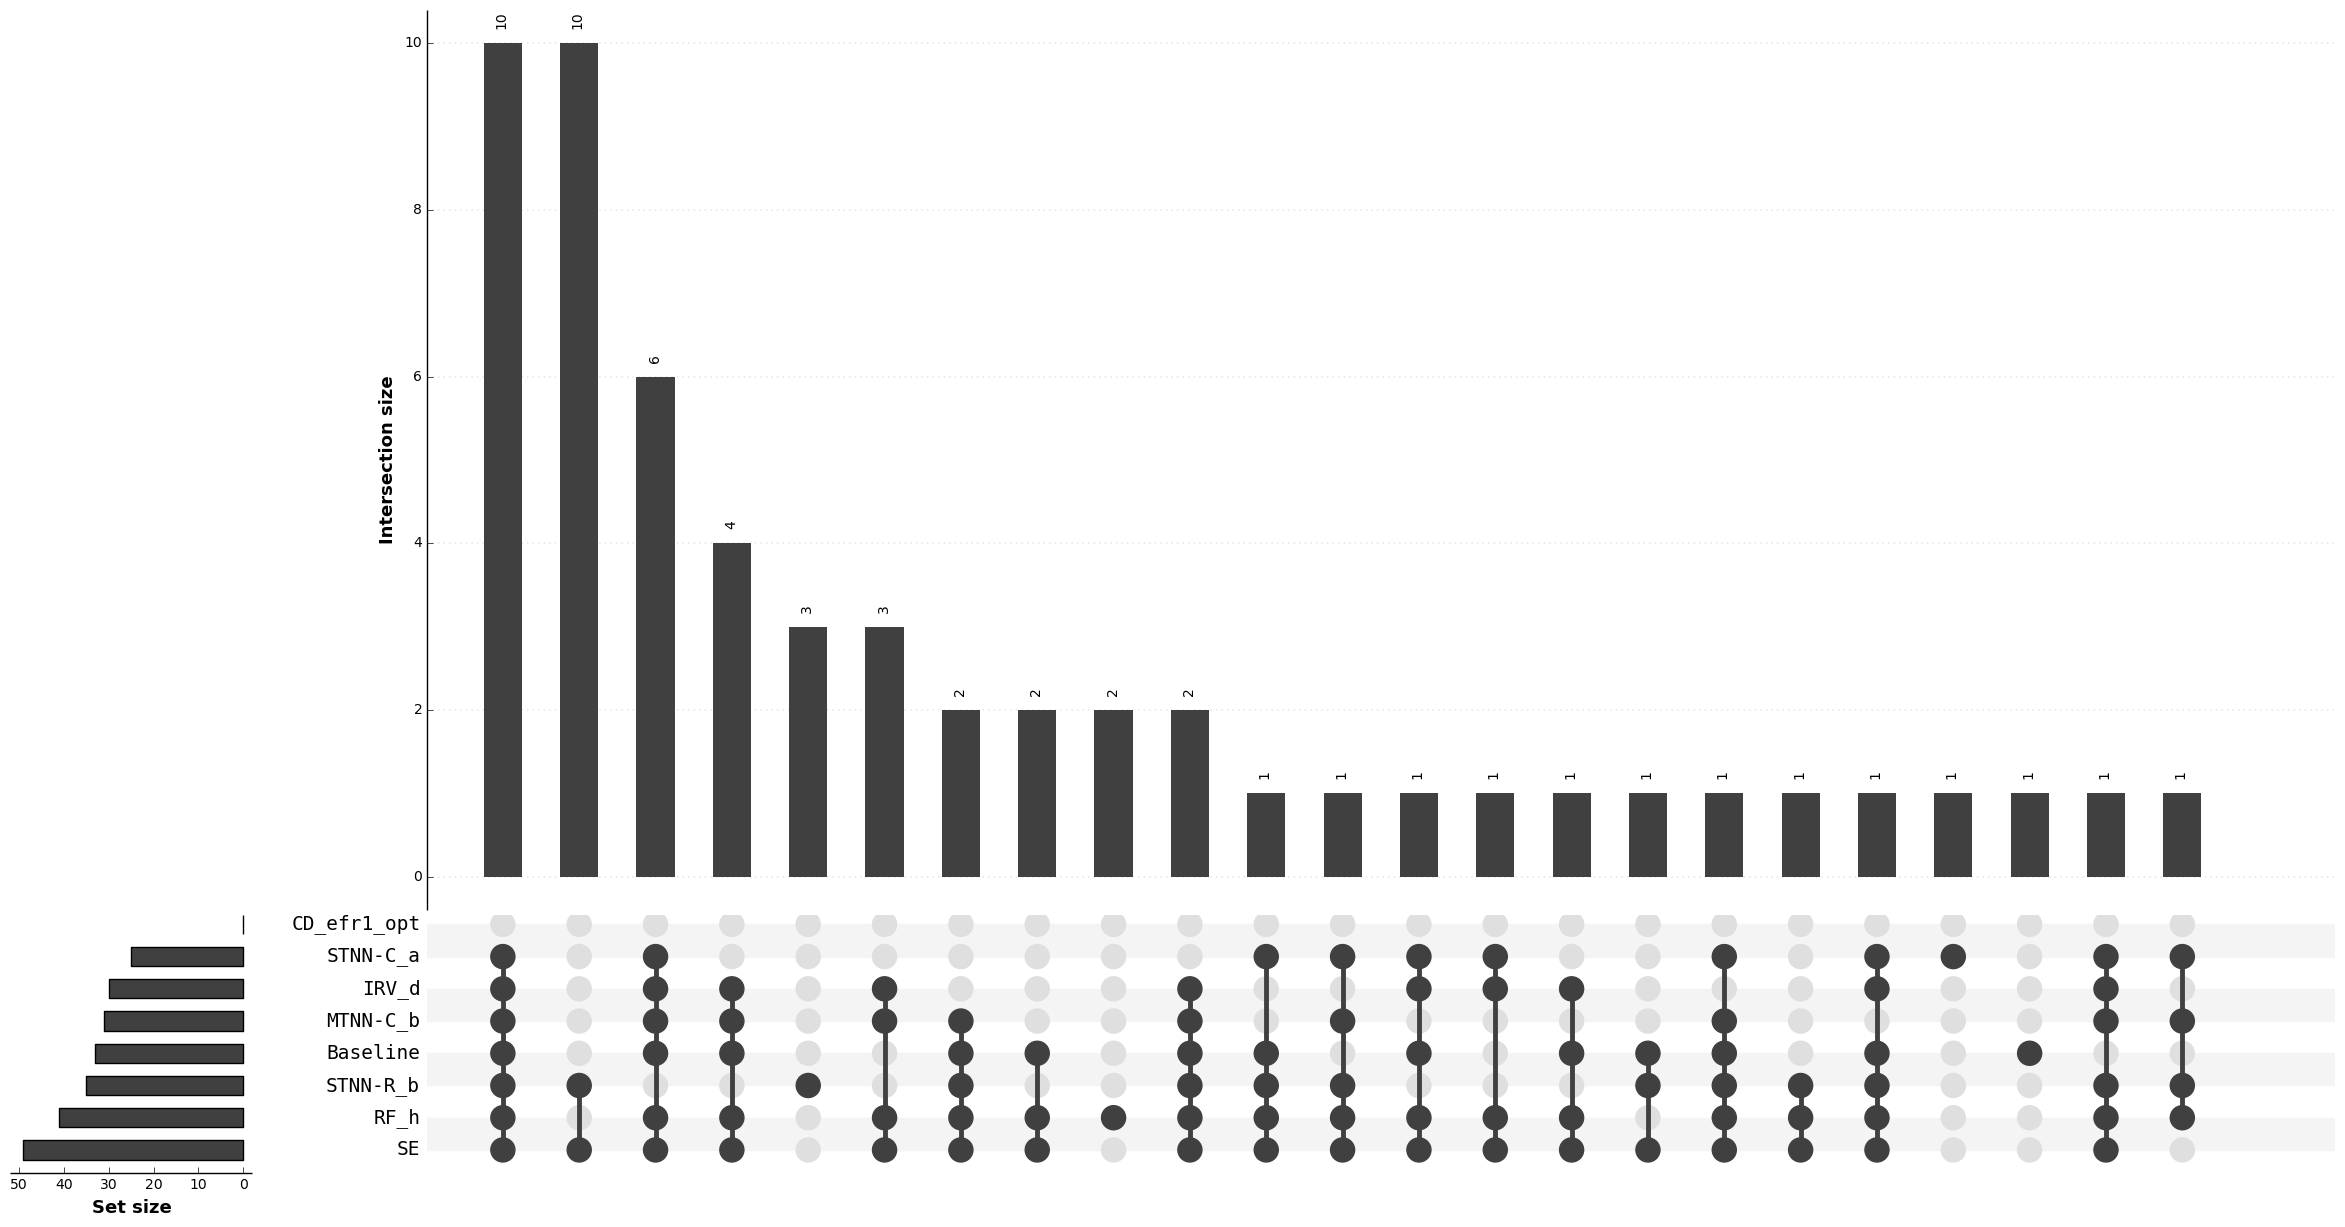

In [5]:
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 100))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/venn_diagram', bbox_inches='tight')

### Venn Diagram on IRV + RF

In [6]:
selected_names = ['IRV_a', 'IRV_b', 'IRV_c', 'IRV_d', 'IRV_e',
                  'RandomForest_a', 'RandomForest_b', 'RandomForest_c',
                  'RandomForest_d', 'RandomForest_e', 'RandomForest_f',
                  'RandomForest_g', 'RandomForest_h']

plot_dict = {}

for model_name in selected_names:
    positive_rank = rank_df[rank_df['label']>0][model_name]
    positive_rank = positive_rank.where(positive_rank<250)
    positive_rank = positive_rank.dropna()
    filtered_index = positive_rank.keys()
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

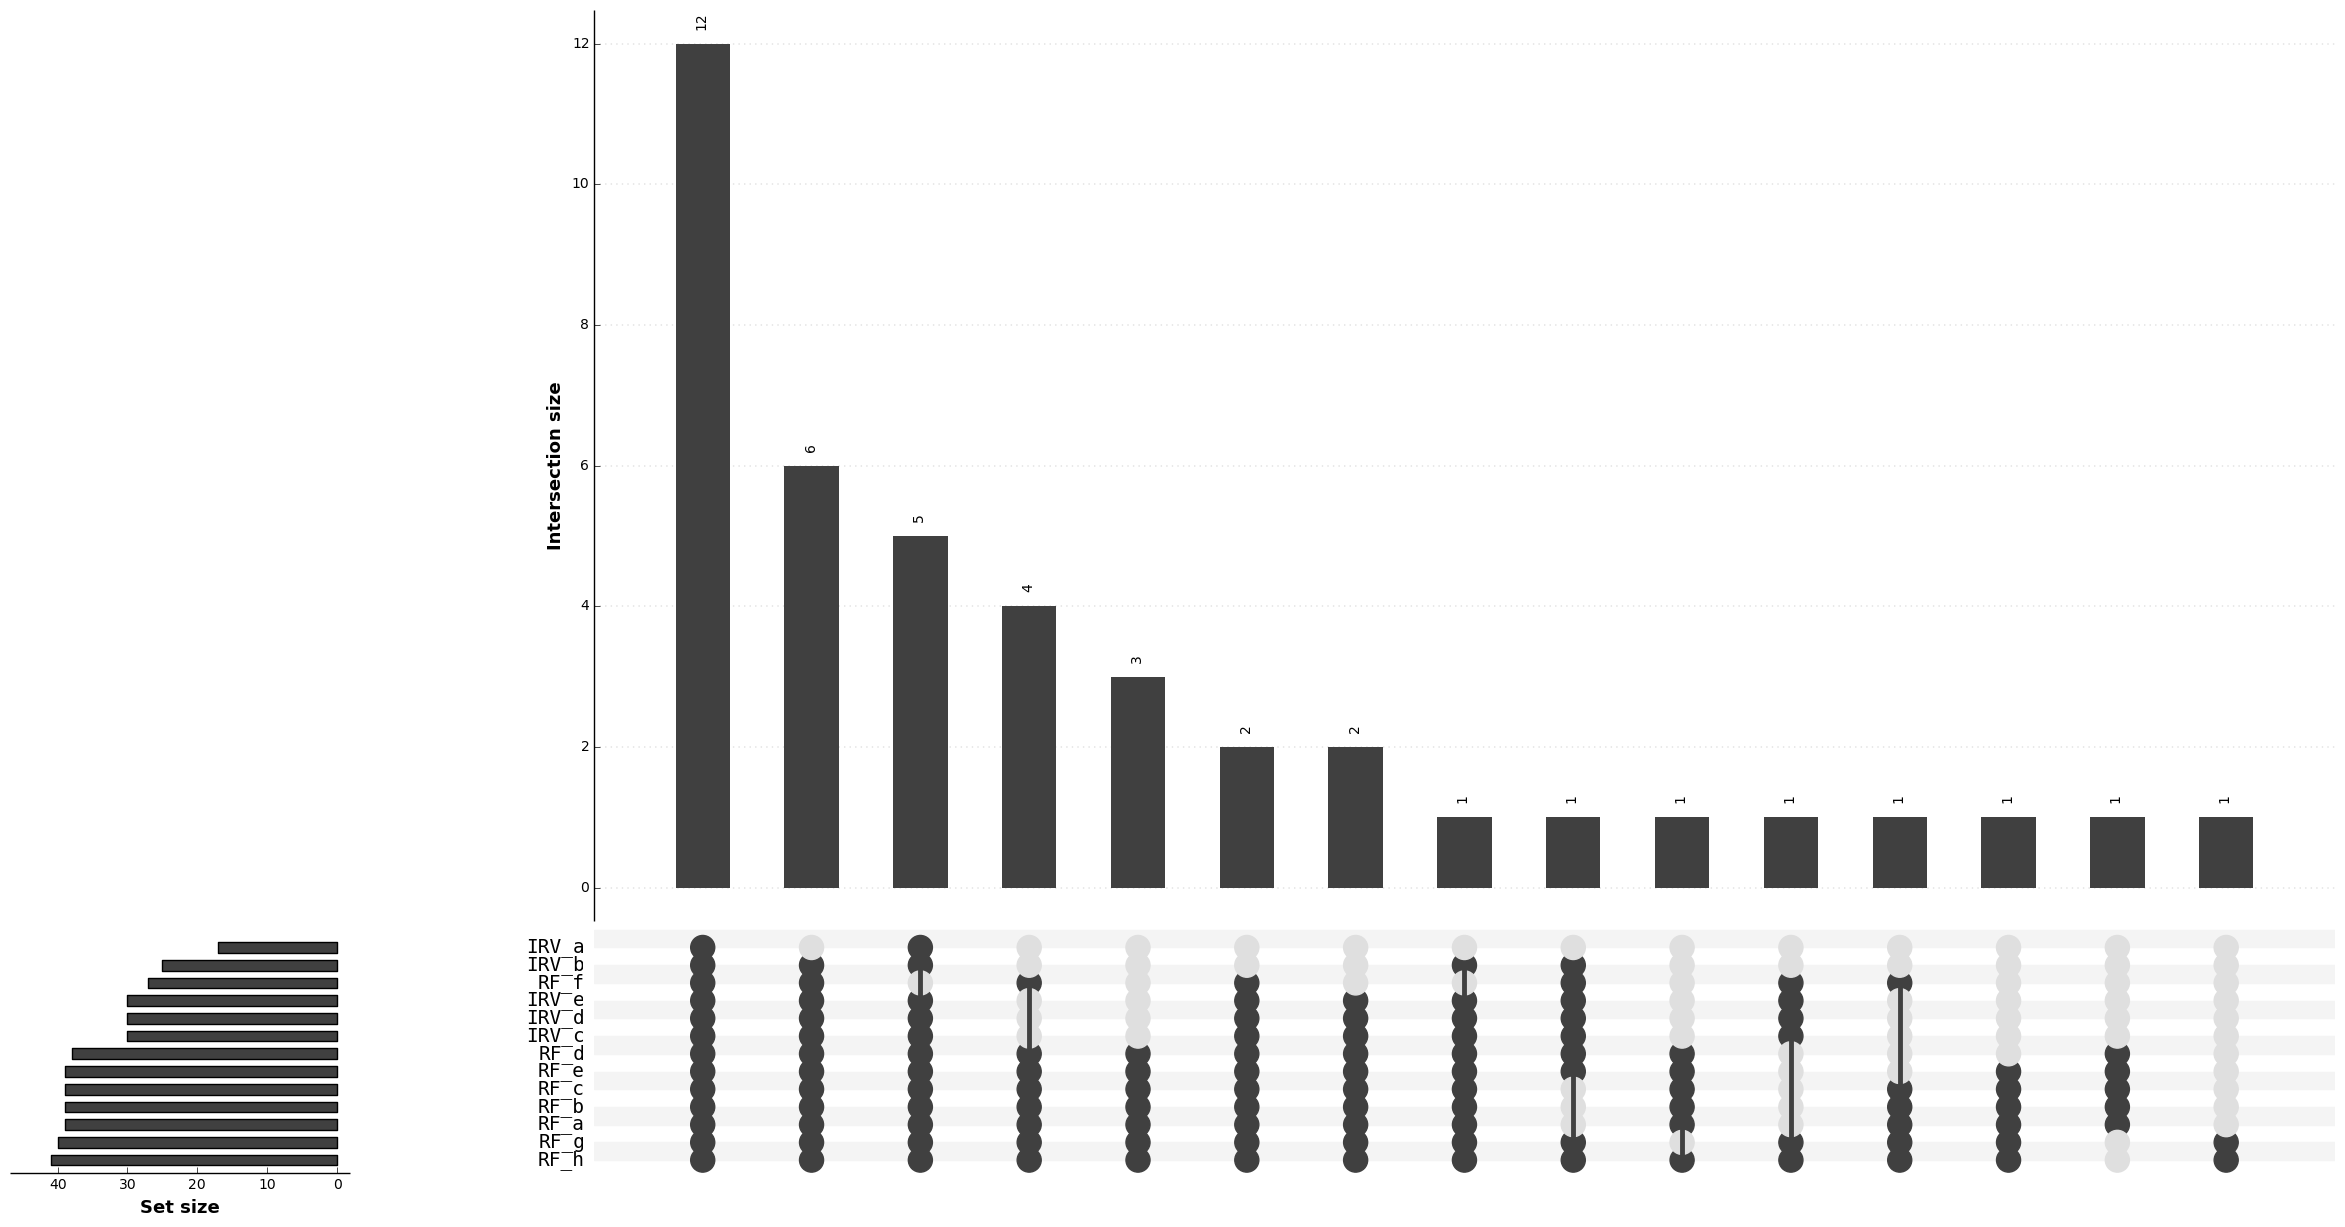

In [7]:
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 100))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/IRV_RF', bbox_inches='tight')

### Venn Diagram on Neural Networks

In [8]:
selected_names = ['SingleRegression_a', 'SingleRegression_b',
                  'SingleClassification_a', 'SingleClassification_b',
                  'MultiClassification_a', 'MultiClassification_b',
                  'LSTM_a', 'LSTM_b']

plot_dict = {}

for model_name in selected_names:
    positive_rank = rank_df[rank_df['label']>0][model_name]
    positive_rank = positive_rank.where(positive_rank<250)
    positive_rank = positive_rank.dropna()
    filtered_index = positive_rank.keys()
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

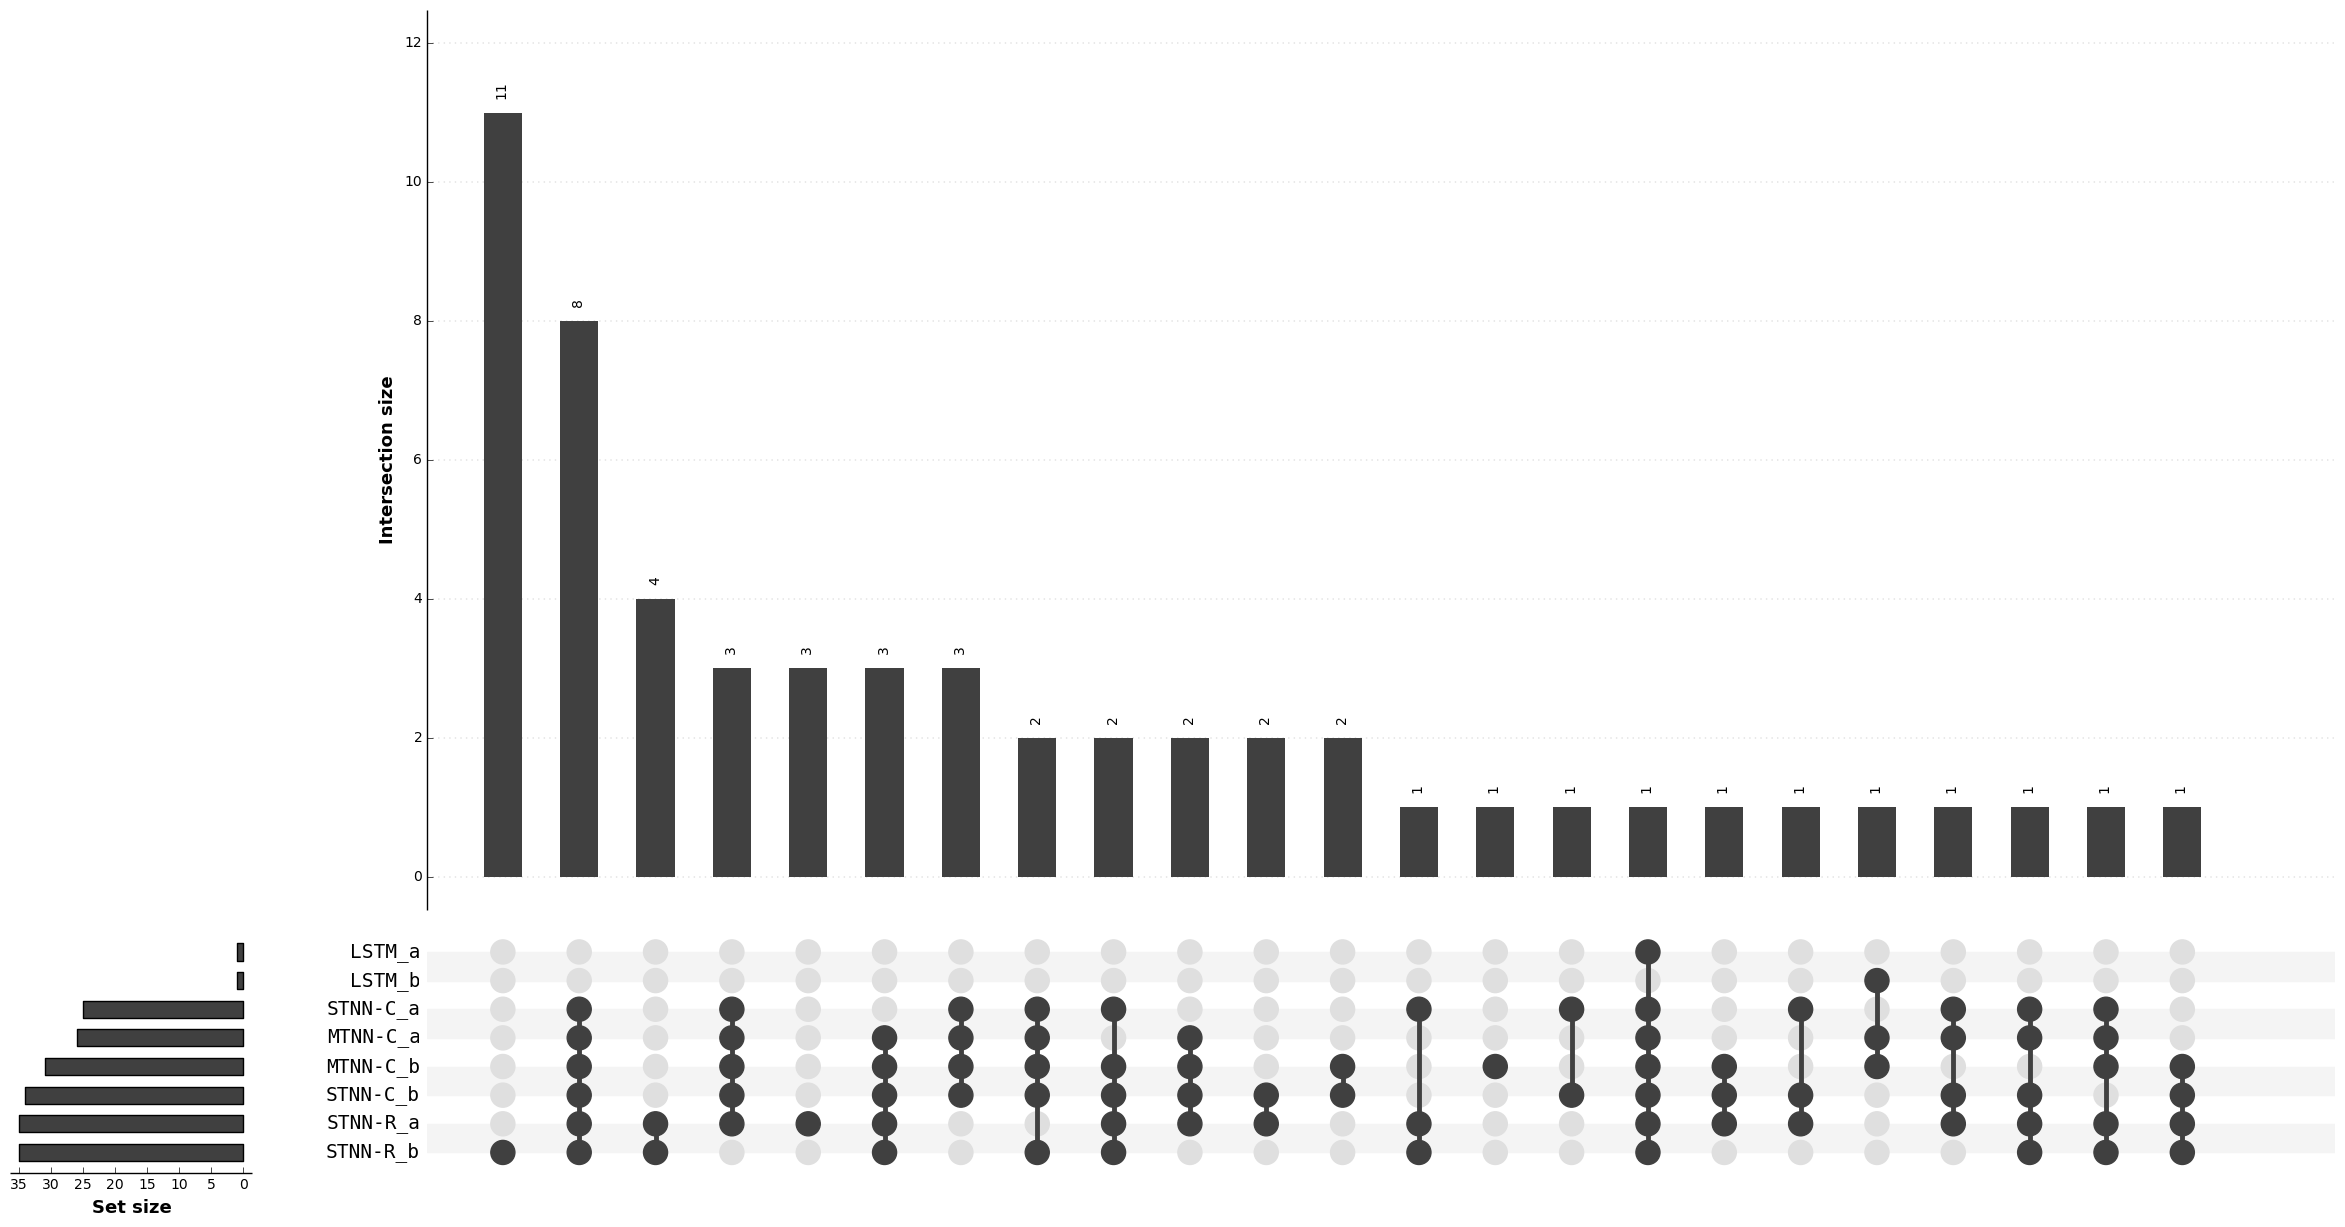

In [9]:
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 100))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/neural_network', bbox_inches='tight')

### Venn Diagram on Docking

In [10]:
selected_names = ['ConsensusDocking_efr1_opt', 'ConsensusDocking_max', 'ConsensusDocking_mean', 
                  'ConsensusDocking_median', 'ConsensusDocking_rocauc_opt']

plot_dict = {}

for model_name in selected_names:
    positive_rank = rank_df[rank_df['label']>0][model_name]
    positive_rank = positive_rank.where(positive_rank<250)
    positive_rank = positive_rank.dropna()
    filtered_index = positive_rank.keys()
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

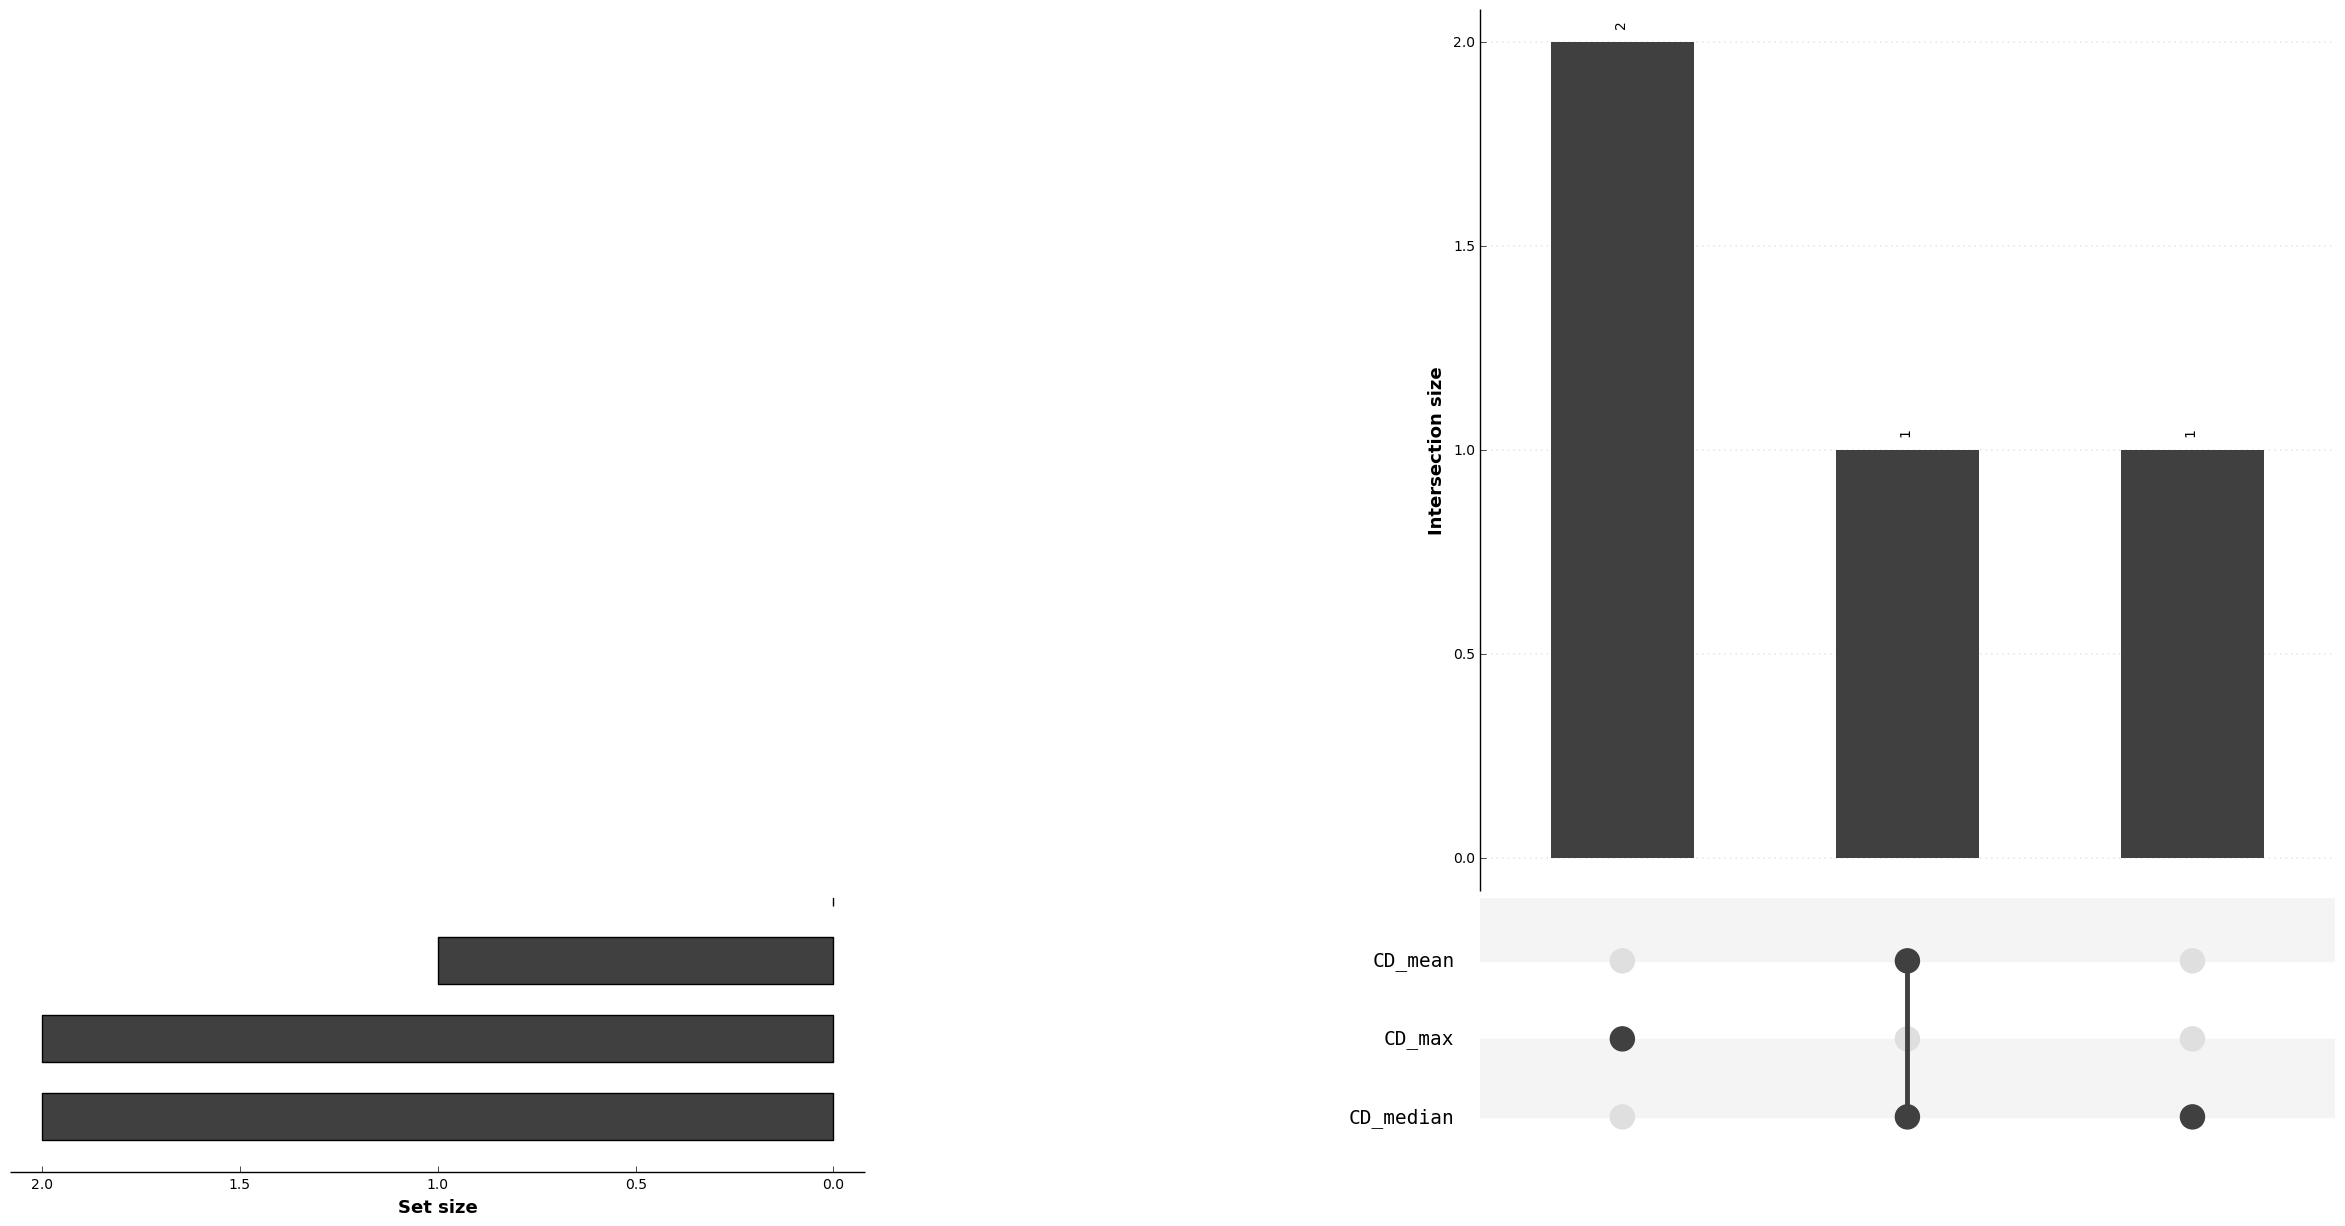

In [11]:
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 100))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/consensus_docking', bbox_inches='tight')

In [12]:
selected_names = ['Docking_ad4', 'Docking_dock6', 'Docking_fred', 'Docking_hybrid', 'Docking_plants', 
                  'Docking_rdockint', 'Docking_rdocktot', 'Docking_smina', 'Docking_surflex']

plot_dict = {}

for model_name in selected_names:
    positive_rank = rank_df[rank_df['label']>0][model_name]
    positive_rank = positive_rank.where(positive_rank<250)
    positive_rank = positive_rank.dropna()
    filtered_index = positive_rank.keys()
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

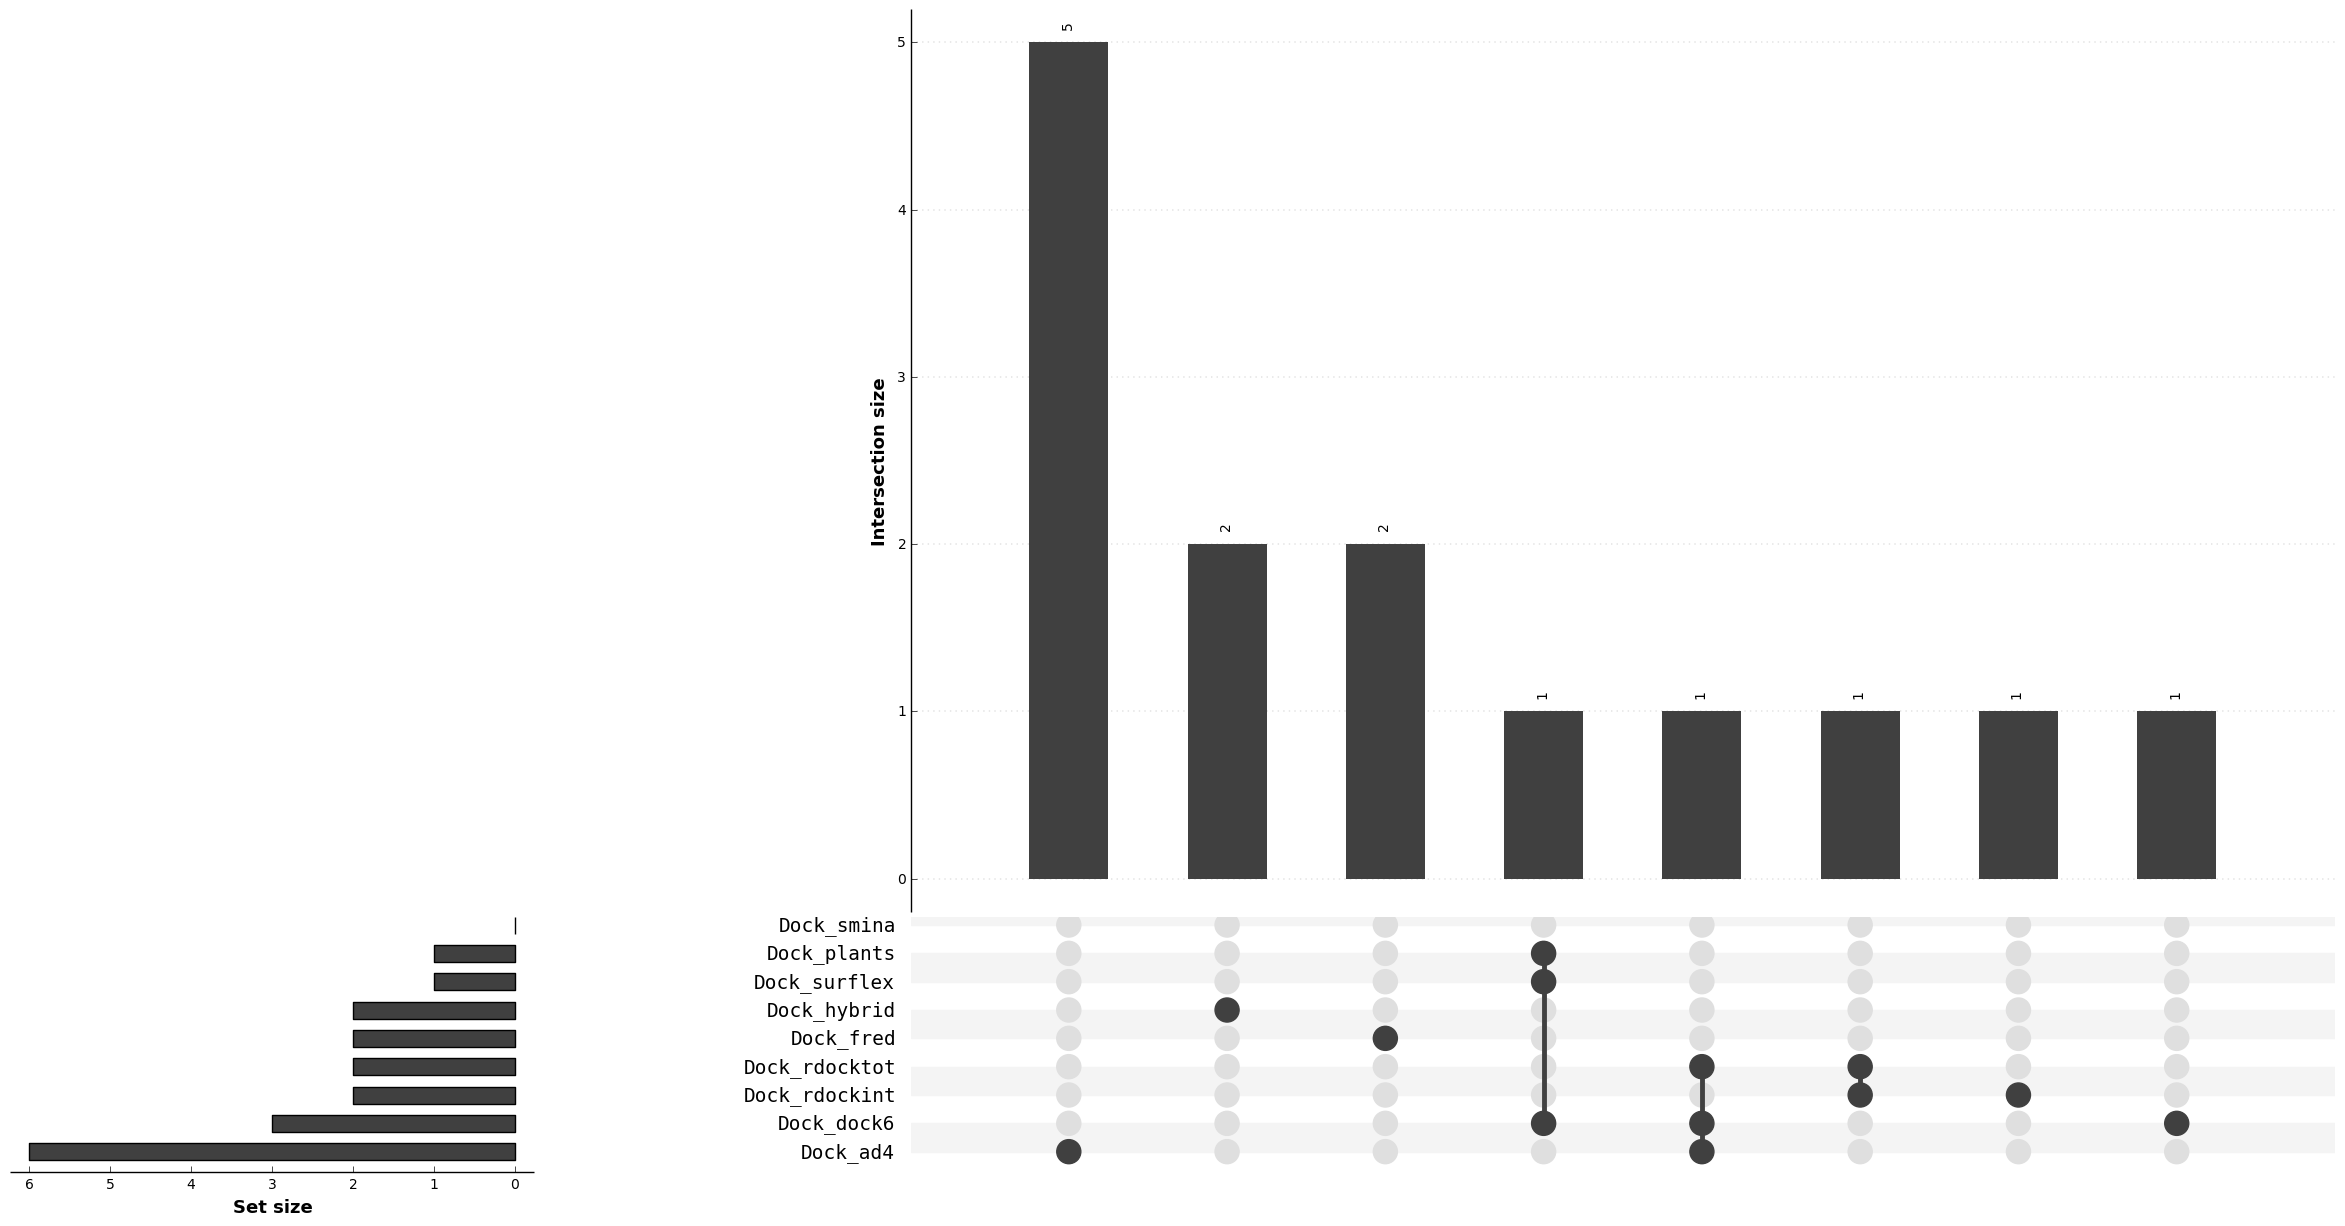

In [13]:
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 100))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/docking', bbox_inches='tight')